# Crowdflower Search Results Relevance

Educational take on one of the more popular past [kaggle challenges](https://www.kaggle.com/c/crowdflower-search-relevance/data) from 2015 with LLMs. Note that this is not an appropriate approach for the problem and is done only for fun! See the second notebook (crowdflower_classical) for a more sensible approach

In [244]:
import pandas as pd
df = pd.read_csv('train.csv')
print(df.describe())
print(df.isna().sum())
df.sample(10)

                 id  median_relevance  relevance_variance
count  10158.000000      10158.000000        10158.000000
mean   16353.103071          3.309805            0.377863
std     9447.106683          0.980666            0.389707
min        1.000000          1.000000            0.000000
25%     8078.750000          3.000000            0.000000
50%    16349.500000          4.000000            0.471000
75%    24570.750000          4.000000            0.471000
max    32668.000000          4.000000            1.470000
id                        0
query                     0
product_title             0
product_description    2444
median_relevance          0
relevance_variance        0
dtype: int64


,id,query,product_title,product_description,median_relevance,relevance_variance
9904,31830,bike lock,Masterlock Cable And Key 5-ft.,Secure your bicycle on a bike rack with this c...,3,0.748
4505,14543,full tang knife,GW1538BONE Bone Handle Gut Hook Full Tang Skin...,"FeaturesFull tang, bone handle, gut hook skinn...",4,0.000
1487,4809,wall clocks,New Fashion Large Number Wall Clock Diy 3D Mir...,eBay item number:361076423179\n\n\n\tSeller as...,2,1.020
6468,20846,leather mens briefcase,McKlein Ladies Leather Briefcase - Red,This ladies' briefcase by McKlein is a fashion...,2,0.471
6308,20365,white jeans,Bluberry Women's Slim Cut Colored Denim Jeans,"ITEM#: 16728155\nThe fashionista's favorite, t...",4,0.800
5154,16619,an extremely goofy movie,"An Extremely Goofy Movie (VHS, 2000) CLAM SHELL",eBay item number:291435965025\n\n\n\tSeller as...,4,0.000
6247,20164,car window sticker,US Air Force Logo Bumper Sticker,United States Air Force Logo Bumper Sticker: S...,2,0.471
5150,16610,wii,BD&A Wii Fit Neoprene Bag (Wii),NaN,2,0.943
5956,19172,playstation 4,PS4 - Knack,He's mean. He's mighty. He's powerful. He's......,2,1.020
8494,27355,face cream,"FUJI BEE VENOM CREAM New, Anti-aging, Face, Sk...",NaN,3,0.471


One can see that there are quite a few missing product descriptions, but otherwise the dataset is fine and product title is sufficient to rate relevance. So, as a first step, we can replace NaNs with empty strings.

In [245]:
df.loc[df['product_description'].isna(),'product_description'] = ''

Now we can proceed to set a benchmark using an LLM. The idea is to:
- generate embeddings for query string to identify similar queries
- use subset of the training set to define good examples for a few-shot promt for LLM asking to rate relevance of a given query using those examples
- repeat process with a different set of examples several times and calculate median

I use here *nomic-embed-text* (=overkill, but that's an LLM-based solution!) for embeddings and small versions of gemma/llamma as LLM (both via ollama) for speed/cost.

In [246]:
import ollama
from tqdm.notebook import tqdm
tqdm.pandas()
df['query_embedding'] = df['query'].progress_apply(lambda x: ollama.embeddings(model='nomic-embed-text', prompt=x)['embedding'])

  0%|          | 0/10158 [00:00<?, ?it/s]

We can also create a separate columns containing concatenated query/response and same text plus answer for few shot prompting:

In [247]:
df['prompt_template'] = "Query: " + df['query'] + '\n Result: ' + df['product_title'] + ' ' + df['product_description'] + '\n Relevance: '+ df['median_relevance'].astype(str)
df['query_result'] = "Query: " + df['query'] + '\n Result: ' + df['product_title'] + ' ' + df['product_description'] 
df.sample(3)


,id,query,product_title,product_description,median_relevance,relevance_variance,query_embedding,prompt_template,query_result
6104,19663,electric griddle,Oster 16,"With a 16"" x 10"" cooking surface and an adjust...",4,0.000,"[-0.40113887190818787, 2.41182804107666, -4.00...",Query: electric griddle\n Result: Oster 16 Wit...,Query: electric griddle\n Result: Oster 16 Wit...
1298,4193,led monitor,Planar PXL2240MW 22 Edge LED LCD Touchscreen M...,"The Planar PXL2240MW is a 22"" budget-friendly ...",4,0.943,"[-0.41080495715141296, 1.3763008117675781, -3....",Query: led monitor\n Result: Planar PXL2240MW ...,Query: led monitor\n Result: Planar PXL2240MW ...
5650,18170,gold dress,Gold SeriesÜ¢ Men's Big & Tall Blue Wrinkle-F...,"From the boardroom to an anniversary dinner, t...",1,0.471,"[-0.18501344323158264, 1.2429983615875244, -3....",Query: gold dress\n Result: Gold SeriesÜ¢ Men...,Query: gold dress\n Result: Gold SeriesÜ¢ Men...


The next step is to extract relevant examples. Note that the queries are not unique, i.e. there are at least 8 samples of the same query (sometimes more), so feeding similar queries with different answers seems like a natural choice:

In [248]:
df['query'].value_counts()

query
wireless mouse             113
rachel ray cookware         91
memory foam pillow          90
bike lock                   84
16 gb memory card           64
                          ... 
longboard pads              13
silicone toe separators     12
8 ounce mason jars          10
polo bear sweater           10
dollhouse bathtub            8
Name: count, Length: 261, dtype: int64

Note that similar is not necessarily the same as it is not guaranteed that the test set will contain same queries as training set. Use embeddings and cosine similarity for that:

In [283]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_n_closest_cosine(query_text, n=3):
    # get target embedding
    target_embedding = np.array(ollama.embeddings(model='nomic-embed-text', prompt=query_text)['embedding']).reshape(1, -1)
    # exclude example if it is found in training set
    df_mdf = df[(df['query_result']!=query_text) & (df['relevance_variance'] == 0) ] # use only clean examples for few shot!
    # Calculate cosine similarities
    similarities = cosine_similarity(np.stack(df_mdf['query_embedding'].values), target_embedding).flatten()
    # Get indices of the top n+1 closest (excluding the target itself at index)
    closest_indices = np.argsort(-similarities)[:n]
    # Return the closest matches
    return df_mdf.iloc[closest_indices]['prompt_template']

Now we can draft function for scoring. I use *n_examples* for few shot prompting and repeat procedure *n_rounds* with different examples, i.e. we need n_examples times n_rounds cases:

In [294]:
from scipy.stats import mode

prompt_intro = """
You are an expert search quality analyst with extensive experience in evaluating 
the relevance of search results. Your task is to assess the relevance of search query 
results on a scale from 1 to 4 and respond with a single number. The relevance scale is

1 - Not relevant at all
2 - Somewhat relevant, but missing key information or outdated
3 - Mostly relevant, with minor issues or omissions
4 - Highly relevant and directly answers the query

You have a deep understanding of user intent and can accurately judge how well a search result matches the user's query. 
Please use the following examples as a guide to rate the relevance of the given search query and result:\n"""



def get_relevance_text(query_text, n_examples=3, n_rounds=5, model='llama3-chatqa'):
    prompt_outro = f'Now, rate the relevance of the following search query result on a scale from 1 to 4 and respond with a single number. Be sure not to include any other text in your response and that the score you output is strictly between 1 and 4. If you do not know, just guess. The text to rate: {query_text}'
    examples = get_n_closest_cosine(query_text, n_examples*n_rounds)
    res = []
    for r in range(n_rounds):
        example_part = ''
        for exn,ex in enumerate(examples[r*n_examples:(r+1)*n_examples]):
            example_part+= f'Example {exn+1}\n' + ex + '\n'
        prompt = prompt_intro + example_part + prompt_outro
        response = ollama.chat(model=model, messages=[{'role': 'user','content': prompt,},])
        try:
            # print(response['message']['content'])
            res.append(int(response['message']['content']))
        except:
            pass
    # print(res)
    try:
        return int(mode(res).mode) # effectively majority vote
    except:
        return np.nan

Let us test the results on a subset of training set:

In [297]:
df_short = df.sample(n=100)
# get_relevance_text(df_short['query_result'].iloc[0]) # to test the model output
df_short['llm_rank'] = df_short['query_result'].progress_apply(get_relevance_text)

  0%|          | 0/100 [00:00<?, ?it/s]

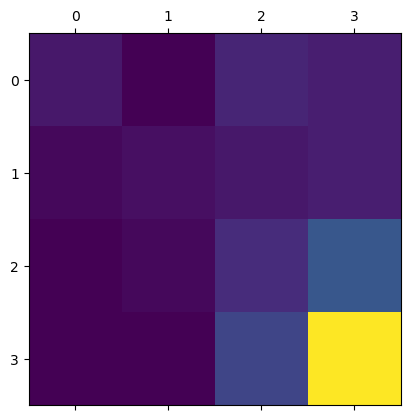

In [298]:
import pylab as plt
plt.matshow(pd.crosstab(df_short['median_relevance'],df_short['llm_rank']))

In [299]:
df_short['llm_rank'].describe()

count    100.000000
mean       3.580000
std        0.741007
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        4.000000
Name: llm_rank, dtype: float64

And evaluate results according to competition metrics:

In [300]:
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(df_short['median_relevance'], df_short['llm_rank'], weights='quadratic')
print(f"Quadratic weighted kappa for subset is {qwk}")

Quadratic weighted kappa for subset is 0.4323342415985467


Not really impressive (the winner had 0.72 or so, and 0.43 is not even in top 1000), and very wasteful! Accuracy can probably be improved with better prompting, more rounds or more complex models, but processing already takes quite a bit of compute (few seconds per row each on MBP M1 depending on number of rounds/examples). The message is thus that it's not always sensible to use LLMs even for NLP tasks.

Note, however, that there is one major advantage of this approach (even if not in context of the particular competition). Basically, neither quality nor even availability of the training data matters that much for LLMs! In principle, results will not be much worse with generic prompt not tuned to specific use case, especially if more complex models and more attempts would be taken. That's a valid use case, but not really in line with spirit of the computation (and LLMs were not available in 2015), so I just write down how the application to the test would be but not run it:

In [291]:
# df_test = pd.read_csv('test.csv')
# df_test.loc[df_test['product_description'].isna(),'product_description'] = ''
# df_test['query_result'] = "Query: " + df_test['query'] + '\n Result: ' + df_test['product_title'] + ' ' + df_test['product_description'] 
# df_test['llm_rank'] = df_test['query_result'].progress_apply(get_relevance_text)
# df_test